# Introduction
The goal of this notebook is to demonstrate how the computational model can be fitted to clinical measurements during both normal sinus rhythm and atrial fibrillation.
#### 1) Loading packages
#### 2) Calibrate the model
The example code calibrates the model to a male and a female patient. Because the clinical data from the SMURF study cannot be shared publicly, this example will use two synthetic patients for the parameter calibration. The target values for pressures, volumes and ejection fraction were computed as the population averages of 1) all men in the SMURF cohort, and 2) all women in the SMURF cohort. The model parameter calibration code runs for 2-4 hours, depending on your computer, and will create two folders totalling 3-4GB of storage. If you like to skip the calibration due to time or storage constraints, you can skip to block 3 in this example after running block 1 loading the packages.
#### 3) Creating patient-specific model parameter file
This block will load the model calibration results from block 2 and select the "best" model parameter set according to a cost function. Two new model parameter set files 'input_human_man.json' and 'input_human_woman.json' will be created from the selected best model parameter set from each calibration. The json-files are stored in the /io/input folder. With this example, two files for a man and woman are already available for instant use. If you run both block 2 and 3, these files will be overwritten with newly executed model calibration.
#### 4) Plot calibration results
This block shows the results of the model calibration, where each column (Woman, Man) correspond to one patient. The first row shows the diastolic and systolic blood pressure (DBP, SBP). The second row shows the right ventricular diastolic and systolic pressure (RVDP, RVSP). The third row shows the mean left atrial pressure (LAPavg). The fourth row shows the mean right atrial pressure (RAPavg). The markers show the synthetic measurement computed as population average (black) and simulation results of the "best" model parameter set (blue) in (right) normal sinus rhythm (NSR) and (left) atrial fibrillation (AF). Along the left and right edge of a column, the posterior distribution of the Bayesian history matching is shown from which the final parameter set was selected with the cost function J defined in Eq. 6. in the manuscript.
#### 5) Run simulations in normal sinus rhythm and atrial fibrillation for the parameter set of the synthetic female patient
This block loads the model parameter set for the synthetic female patient and runs one simulation during normal sinus rhythm and one during atrial fibrillation. The class objects 'cg_NSR' and 'cg_AF' contain all the model parameters and simulated outputs for a simulation. If you like to look into all the options that can be selected for the simulation, an extensive explanation is given at the top of the 'rhythm.py' file.
#### 6) Plot LV volume and pressure trends together with LV PV-loop in normal sinus rhythm
The simulated LV volume and pressure trend for 10 regular heartbeats at 60bpm is illustrated together with the PV-loop of these 10 heartbeats during normal sinus rhythm. Because the rhythm is regular, the 10 PV loops are on top of each other.
#### 7) Plot LV volume and pressure trends together with LV PV-loop in atrial
The simulated LV volume and pressure trend for 10 irregular heartbeats at 100bpm is illustrated together with the PV-loop of these 10 irregular heartbeats during atrial fibrillation. Because the rhythm is irregular, none of the 10 PV loops is the same.

# 1) Loading packages

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import os
import json

# Add parent directory to Python path to allow imports from src/
sys.path.insert(0, os.path.dirname(os.getcwd()))

from src.fit_nsr_af_functions import set_simulation_free_parameters, set_simulation_model_constants, get_best_simulation, set_calibration_target, get_clin_target, plot_calibration, plot_volume_pressure

# Load the 'hrv_analysis_felix' branch from the cardiogrowth git repository
cardiogrowth_py_path = str(pathlib.Path(os.getcwd()).parent)
sys.path.append(cardiogrowth_py_path)

from src.wave import Wave
from src.tide import Tide
import src.model_utils as model_utils
from src.cardiogrowth import CardioGrowth
import src.visualize as vs

# Predefine model properties (General properties for a human, some parameters can be overwritten for specific patients)
input_file = cardiogrowth_py_path + "/io/input/input_human"

# In this folder will be the calibration files stored
dir_calibration = pathlib.Path(cardiogrowth_py_path + "/calibration")

# Set directories
dir_root = pathlib.Path().absolute()


# 2) Calibrate the model
The example code calibrates the model to a male and a female patient. Because the clinical data from the SMURF study cannot be shared publicly, this example will use two synthetic patients for the parameter calibration. The target values for pressures, volumes and ejection fraction were computed as the population averages of 1) all men in the SMURF cohort, and 2) all women in the SMURF cohort. The model parameter calibration code runs for 2-4 hours, depending on your computer, and will create two folders totalling 3-4GB of storage. If you like to skip the calibration due to time or storage constraints, you can skip to block 3 in this example after running block 1 loading the packages.

In [ ]:
for p_idx, patient in enumerate(['man', 'woman']):
    dir_case = dir_calibration / patient

    # Set the target value for the parameter calibration
    output_fit = set_calibration_target(patient)

    # Set the lower and upper boundaries of the fitted model parameters
    pars = set_simulation_free_parameters()

    # Set the model constants for the parameter calibration
    model_constants = set_simulation_model_constants(patient)

    # Initialize wave loop parameters
    i_wave = 0
    nroy = None
    not_flooded = True
    sim_dirs = []

    # Start history matching until convergence is reached
    while not_flooded:

        # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
        wave_threshold = max(5 - i_wave/2, 2)

        # Initialize wave
        wave = Wave(i_wave, dir_case, wave_threshold, pars, output_fit, nroy=nroy, clear_log=(i_wave == 0), constants=model_constants)

        # Run simulations for all parameter sets in current wave set
        wave.x_sim, wave.y_sim, sim_dirs = model_utils.run_forest_run(wave, input_file, sim_dirs, constants=model_constants, log_file=wave.log_file, run_sims=True)

        # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
        wave.flood()

        # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
        not_flooded = wave.is_flooded(i_wave, min_waves=7, max_waves=20)
        nroy = wave.nroy
        i_wave += 1

    # Run posterior simulations
    wave.x_posterior, wave.y_posterior, _ = model_utils.run_forest_run(wave, input_file, [], constants=model_constants, log_file=wave.log_file, posterior=True)
    wave.pickle_wave()

    # I do this to store all the variables in the given y_names into the sim_results.csv file
    wave.y_names = ['SBP NSR', 'SBP AF', 'DBP NSR', 'DBP AF', 'RVSP NSR', 'RVSP AF', 'RVDP NSR', 'RVDP AF', 'LAMP NSR', 'LAMP AF', 'RAMP NSR', 'RAMP AF', 'LAEF NSR', 'LAEF AF', 'RAEF NSR', 'RAEF AF', 'LVEF NSR', 'LVEF AF', 'RVEF NSR', 'RVEF AF', 'LAMAXV NSR', 'LAMAXV AF', 'RAMAXV NSR', 'RAMAXV AF', 'LVDV NSR', 'LVDV AF', 'RVDV NSR', 'RVDV AF', 'CO NSR', 'CO AF']
    model_utils.analyze_model(wave.dir.parent / wave.posterior_label, wave.x_names, wave.y_names, constants=model_constants, m_outlier=5.0, log_file=None,
                  remove_outliers=True, percentile=0.95)

    # Plot all results
    tide = Tide(dir_case)
    tide.plot_nroy_x(n_samples=1000)
    tide.roll(nroy_full=False)

# 3) Creating patient-specific model parameter file
This block will load the model calibration results from block 2 and select the "best" model parameter set according to a cost function. Two new model parameter set files 'input_human_man.json' and 'input_human_woman.json' will be created from the selected best model parameter set from each calibration. The json-files are stored in the /io/input folder. With this example, two files for a man and woman are already available for instant use. If you run both block 2 and 3, these files will be overwritten with newly executed model calibration.

In [2]:
# Write the best simulation results of all patients into a csv file
for patient in ['man', 'woman']:
    # Load all simulation results from the calibration
    sim_results = pd.read_csv(str(dir_calibration / patient / 'Posterior/sim_results.csv'))
    sim_results.reset_index(drop=True, inplace=True)
    clin_target = get_clin_target(patient)
    clin_normalize = pd.DataFrame({'LAMAXV NSR mean': [56.24], 'LAMAXV NSR std': [14.75], 'RAMAXV NSR mean': [40.76], 'RAMAXV NSR std': [13.24]}, index=['population'])
    best_sim, best_sim_idx = get_best_simulation(sim_results, clin_target, clin_normalize)

    # Read the generic human model parameter file
    with open(cardiogrowth_py_path + '/io/input/input_human.json', 'r') as file:
        dictionary = json.load(file)

    dictionary['Circulation']['sbv'] = best_sim['SBV']
    dictionary['Heart']['sf_act'] = [best_sim['SAct']] * 21 + [best_sim['SAct_a']] * 2
    dictionary['Resistances']['ras'] = best_sim['Ras']
    dictionary['Resistances']['rap'] = best_sim['Rap']
    dictionary['Capacitances']['cas'] = dictionary['Capacitances']['cas'] * best_sim['scale_Cs']
    dictionary['Capacitances']['cvs'] = dictionary['Capacitances']['cvs'] * best_sim['scale_Cs']
    dictionary['Capacitances']['cap'] = dictionary['Capacitances']['cap'] * best_sim['scale_Cp']
    dictionary['Capacitances']['cvp'] = dictionary['Capacitances']['cvp'] * best_sim['scale_Cp']
    dictionary['Heart']['tad'] = [best_sim['tad']] * 21 + [best_sim['tad_a']] * 2
    dictionary['Heart']['am_ref'] = [best_sim['AmRefLfw']/11, best_sim['AmRefSw']/5, best_sim['AmRefSw']/5, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefSw']/5, best_sim['AmRefSw']/5, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefSw']/5, best_sim['AmRefLfw']/11, best_sim['AmRefLfw']/11, best_sim['AmRefRfw']/5, best_sim['AmRefRfw']/5, best_sim['AmRefRfw']/5, best_sim['AmRefRfw']/5, best_sim['AmRefRfw']/5, best_sim['AmRefLA'], best_sim['AmRefRA']]
    dictionary['AF'] = {}
    dictionary['AF']['CircChangeCirc'] = best_sim['CircChangeCirc_AF']
    dictionary['AF']['CircChangeTad'] = best_sim['CircChangeTad_AF']

    # Write the updated model parameter file to a json file
    with open(cardiogrowth_py_path + '/io/input/input_human' + '_' + patient + '.json', 'w') as file:
        json.dump(dictionary, file, indent=4)

# 4) Plot calibration results
This block shows the results of the model calibration, where each column (Woman, Man) correspond to one patient. The first row shows the diastolic and systolic blood pressure (DBP, SBP). The second row shows the right ventricular diastolic and systolic pressure (RVDP, RVSP). The third row shows the mean left atrial pressure (LAPavg). The fourth row shows the mean right atrial pressure (RAPavg). The markers show the synthetic measurement computed as population average (black) and simulation results of the "best" model parameter set (blue) in (right) normal sinus rhythm (NSR) and (left) atrial fibrillation (AF). Along the left and right edge of a column, the posterior distribution of the Bayesian history matching is shown from which the final parameter set was selected with the cost function J defined in Eq. 6. in the manuscript.

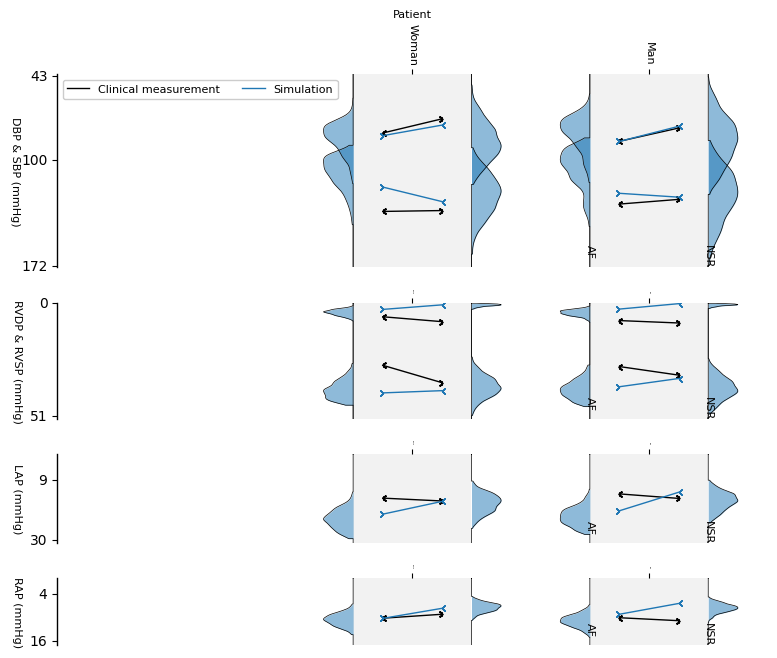

In [3]:
plot_calibration(dir_calibration)

# 5) Run simulations in normal sinus rhythm and atrial fibrillation for the parameter set of the synthetic female patient
This block loads the model parameter set for the synthetic female patient and runs one simulation during normal sinus rhythm and one during atrial fibrillation. The class objects 'cg_NSR' and 'cg_AF' contain all the model parameters and simulated outputs for a simulation. If you like to look into all the options that can be selected for the simulation, an extensive explanation is given at the top of the 'rhythm.py' file.

In [4]:
file_path = cardiogrowth_py_path + "/calibration/default"

file_woman = cardiogrowth_py_path + '/io/input/input_human_woman'

# Read the generic human model parameter file
with open(file_woman + '.json', 'r') as file:
    dictionary = json.load(file)

cg_NSR = CardioGrowth(model_pars=file_woman)
cg_NSR.rhythm_is_a_dancer(rhythm='NSR',  # Simulate normal sinus rhythm
                      num_beats=10,
                      avn_p4_params=None,
                      desired_rr_char=60,
                      desired_vat_series=None,
                      num_beats_af_launch=None,
                      keep_simulation_data='no_launch',
                      use_converged=False,
                      file_path=file_path,
                      file_name='default_NSR')

cg_AF = CardioGrowth(model_pars=file_woman)
cg_AF.change_pars({'sympathetic_activity_circulation': dictionary['AF']['CircChangeCirc'],
                'sympathetic_activity_tad': dictionary['AF']['CircChangeTad'],
                    })
rr_lookup = pd.read_pickle(
            os.getcwd()[:os.getcwd().rfind('/Computational_model_of_haemodynamics_during_atrial_fibrillation')] + '/Computational_model_of_haemodynamics_during_atrial_fibrillation/notebooks/RR_lookup.pkl')
rr_lookup = rr_lookup[(abs(rr_lookup['HR target'] - 100) < 1.2) &
                      (abs(rr_lookup['RR rmssd target'] - 32.5) < 1) &
                      (abs(rr_lookup['RR sampen target'] - 1.7) < 0.025)]
avn = np.squeeze(rr_lookup[['AVN' + str(i) for i in range(1, 22)]].values)
rr = rr_lookup[['RR' + str(i) for i in range(1, 200)]].values
vat = np.insert(np.cumsum(rr), 0, 0)
cg_AF.rhythm_is_a_dancer(rhythm="AF", num_beats=None, num_beats_af_launch=10, avn_p4_params=avn, desired_rr_char=None, desired_vat_series=vat[:10], n_patches_atria=20, patch_t_delay=np.concatenate([np.zeros(21), -120 * np.ones(2)]), keep_simulation_data='no_launch', use_converged=False, check_params=False, file_path=file_path, file_name='default_AF')

# 6) Plot LV volume and pressure trends together with LV PV-loop in normal sinus rhythm
The simulated LV volume and pressure trend for 10 regular heartbeats at 60bpm is illustrated together with the PV-loop of these 10 heartbeats during normal sinus rhythm. Because the rhythm is regular, the 10 PV loops are on top of each other.

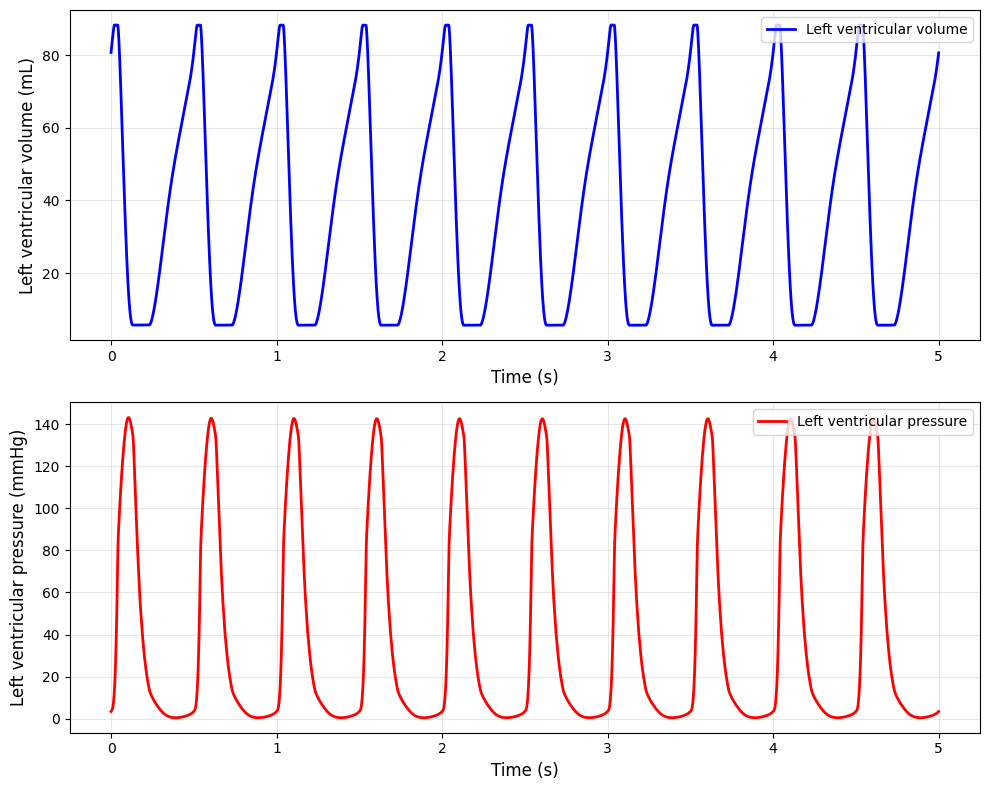

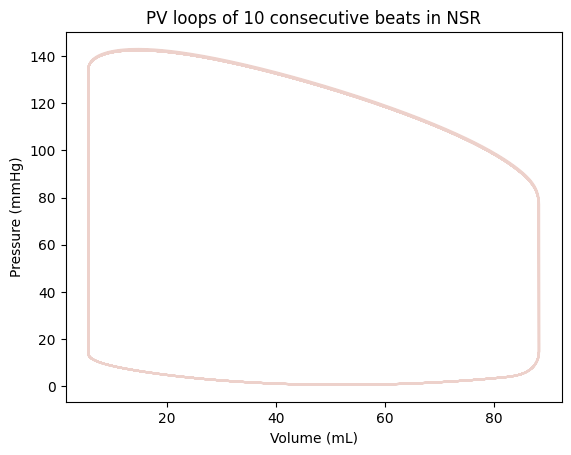

In [5]:
plot_volume_pressure(cg_NSR, compartment=[2], legend='Left ventricular')
vs.pressures_volumes(cg_NSR, show_fig=True, compartment=[2], title='PV loops of 10 consecutive beats in NSR')

# 7) Plot LV volume and pressure trends together with LV PV-loop in atrial
The simulated LV volume and pressure trend for 10 irregular heartbeats at 100bpm is illustrated together with the PV-loop of these 10 irregular heartbeats during atrial fibrillation. Because the rhythm is irregular, none of the 10 PV loops is the same.

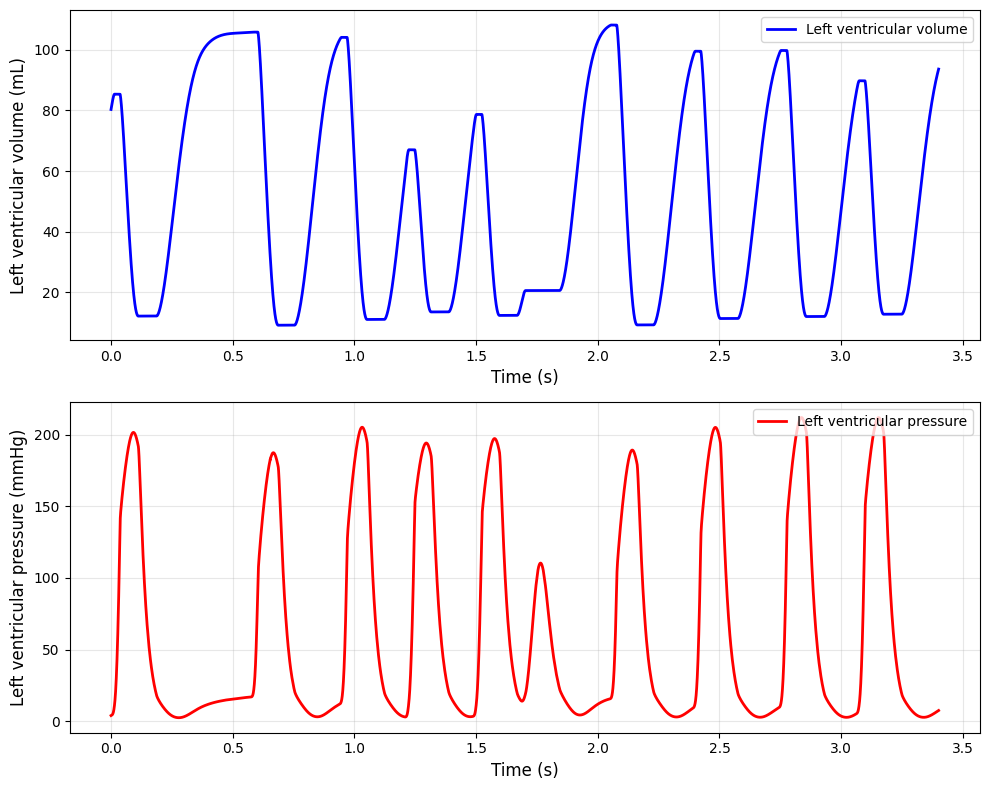

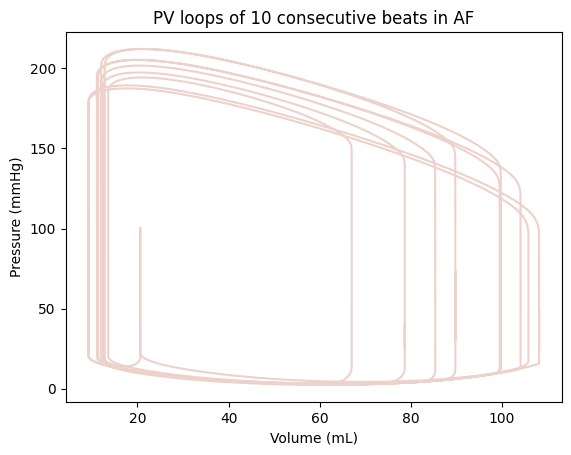

In [6]:
plot_volume_pressure(cg_AF, compartment=[2], legend='Left ventricular')
vs.pressures_volumes(cg_AF, show_fig=True, compartment=[2], title='PV loops of 10 consecutive beats in AF')